Student's Name and Email Address

Boise State University, Department of Chemistry and Biochemistry

## CHEM 324: PChem Lab {-}
# Worksheet 5: Differential Scanning Calorimetry (DSC) {-}

In [386]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.integrate import simpson, cumulative_trapezoid


In [387]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a DSC .txt file. 
    The format of the file should have two rows of headers, one extra line of text at the end, and five columns of data
    The columns are: index, time, heat flow, temperature of sample, temperature of reference

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with four columns: time (in seconds), heat flow (in W/g), 
        temperature of sample (in C), and temperature of reference (in C)
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'], skiprows=2, skipfooter=1, names=['Time','Heat-Flow','Ts','Tr'], sep='\\s+', index_col=0, engine='python', encoding='unicode_escape')
    file_dict['data'] = data
    return

def filter_data(peak_dict,verbose=False):
    """
    Given a file dictionary that contains two values for the time interval to analyze
    create a 'filtered_data' component with only the data in the specified time range

    By default, time_end = 0 corresponds to the end of the file

    Action:
        If not present, load the data from the file into peak_dict['data']
        Add peak_dict['filtered_data'] with only the part of the experiment within time_start and time_end
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    peak_dict['filtered_data'] = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}').copy()

def plot_peak(peak_dict,xaxis='Time'):
    """ 
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}')
    #
    if xaxis not in peak_dict['data']:
        print("ERROR: Invalid value for xaxis argument")
        return
    elif xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.ylabel('Heat Flow [W/g]')
    plt.show()

def plot_peak_list(peak_list,xaxis='Time',key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot temperature vs. time for the selected files  
    """
    if value == '' or key == '':
        peak_shortlist = peak_list
    else :
        peak_shortlist = [f for f in peak_list if f[key] in value ]
    #
    fig, ax = plt.subplots()
    if xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    else:
        print("ERROR: unexpected xaxis label")
        return
    #
    for peak in peak_shortlist : 
        filter_data(peak)
        plt.plot(peak['filtered_data'][xaxis],peak['filtered_data']['Heat-Flow'],label=peak['label'])
    plt.ylabel('Heat-Flow [W/g]')
    plt.legend()
    plt.show()

def line_of_tuple(x,params):
    """ 
    given a list of 3 parameters compute a line according to 
        y(x) = params[2] + params[0]*(x-params[1])
    """
    return params[0]*(x-params[1]) + params[2]

def intersection_of_lines(params1,params2):
    """ 
    Given the equations of two lines (y(x) = params[2] + params[0]*(x-params[1])) 
    find the intersection point: 
        y01 + slope1*(x01 - x) = y02 + slope2*(x02 - x) 
        (slope2 - slope1) * x = (y02 - y01) + (slope2*x02-slope1*x01)
        x = ((y02 - y01) + (slope2*x02-slope1*x01)) / (slope2 - slope1) 
    """
    if params1[0] == params2[0] :
        raise ValueError("ERROR: the two lines are parallel, no (unique) intersection")
    x = (params2[2] - params1[2] - params2[0]*params2[1] + params1[0]*params1[1])/(params1[0]-params2[0])
    y = line_of_tuple(x,params1)
    return x,y

def calc_baseline(peak_dict,xaxis='Time',verbose=False):
    """ 
    Compute a baseline for the data according to a few alternative options

    Baseline types, specified in the peak_dict['baseline_type'] component, can be:
        line-right = a line tangent to the right extreme of the data
        line-left = a line tangent to the left extreme of the data
        line-horizontal-right = a flat line passing throught the right extreme
        line-horizontal-left = a flat line passing throught the left extreme
        integral = a smooth combination of left and right tangents 
        integral-horizontal = a smooth combination of left and right flat lines

    Action: 
        Compute left, right, and full baseline
        Add them to the peak_dict['filtered_data'] component
        Compute peak_dict['Heat-Flow-Clean'], the heat-flow minus the full baseline 
    """
    filter_data(peak_dict)
    filtered_data = peak_dict['filtered_data']
    if filtered_data.empty:
        raise ValueError(f"No data found in the specified time range ({peak_dict['time_start']}–{peak_dict['time_end']}). Check the time bounds.")
    # Drop NaNs and duplicate x-values to avoid zero-division in np.gradient
    filtered_data.dropna(subset=[xaxis, 'Heat-Flow'], inplace=True)
    filtered_data = filtered_data[filtered_data[xaxis].diff().fillna(1) != 0]

    filtered_data.loc[:, 'dHF_dx'] = np.gradient(filtered_data['Heat-Flow'], filtered_data[xaxis])
    #
    if 'line' in peak_dict['baseline_type'] :
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            slope = 0.
        else :
            slope = (yf-yi)/(xf-xi)
        if 'right' in peak_dict['baseline_type'] :
            peak_dict['baseline-left'] = (slope,xf,yf)
            peak_dict['baseline-right'] = (slope,xf,yf)
            filtered_data.loc[:, 'baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        else :
            peak_dict['baseline-left'] = (slope,xi,yi)
            peak_dict['baseline-right'] = (slope,xi,yi)
            filtered_data.loc[:, 'baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
    elif 'integral' in peak_dict['baseline_type'] :
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxi = 0
        else :
            dydxi = filtered_data['dHF_dx'].iloc[0]
        peak_dict['baseline-left'] = (dydxi,xi,yi)
        #
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxf = 0
        else :
            dydxf = filtered_data['dHF_dx'].iloc[-1]
        peak_dict['baseline-right'] = (dydxf,xf,yf)
        filtered_data.loc[:, 'baseline-right'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        filtered_data.loc[:, 'baseline-left'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
        baseline = np.ones(filtered_data['Heat-Flow'].shape)*(yi+yf)*0.5
        for i in range(10):
            gamma = cumulative_trapezoid(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis],initial=0)/simpson(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis])
            baseline = (1-gamma)*filtered_data.loc[:, 'baseline-left'] + gamma*filtered_data.loc[:, 'baseline-right']
        filtered_data.loc[:, 'baseline'] = baseline
    filtered_data.loc[:, 'Heat-Flow-Clean'] = filtered_data['Heat-Flow'] - filtered_data['baseline']
    
def analyze_peak(peak_dict,verbose=False,xaxis='Time'):
    """ 
    """
    calc_baseline(peak_dict,xaxis)
    # Now access the modified DataFrame after baseline calculations
    filtered_data = peak_dict['filtered_data']
    # Compute the integral
    peak_integral = simpson(filtered_data['Heat-Flow-Clean'],filtered_data['Time'])
    peak_dict['integral'] = peak_integral
    peak_integral_xaxis = simpson(filtered_data['Heat-Flow-Clean'],filtered_data[xaxis])
    if verbose : print(f'The peak integral is {peak_integral:8.6f} J/g')
    # Peak position
    if peak_integral < 0 : 
        index_peak = np.argmin(filtered_data['Heat-Flow'])
    else : 
        index_peak = np.argmax(filtered_data['Heat-Flow'])
    x_peak = filtered_data[xaxis].iloc[index_peak]
    y_peak = filtered_data['Heat-Flow'].iloc[index_peak]
    peak_dict['peak'] = (x_peak,y_peak)
    # Inflaction points (max and min of first derivative are zeros of second derivative)
    left_data = filtered_data.iloc[:index_peak]
    if left_data.empty:
        raise ValueError("Left side of peak is empty; cannot determine inflection point.")
    if peak_integral_xaxis < 0 :
        index_inflection_left = np.argmin(left_data['dHF_dx'])
    else :
        index_inflection_left = np.argmax(left_data['dHF_dx'])
    x_infl_left = left_data[xaxis].iloc[index_inflection_left]
    y_infl_left = left_data['Heat-Flow'].iloc[index_inflection_left]
    slope_infl_left = left_data['dHF_dx'].iloc[index_inflection_left]
    peak_dict['inflection1'] = (slope_infl_left, x_infl_left, y_infl_left)
    right_data = filtered_data.iloc[min(index_peak+1, len(filtered_data)-1):]
    if right_data.empty or right_data['dHF_dx'].dropna().empty:
        peak_dict['inflection2'] = peak_dict['inflection1']  # fallback to left
        peak_dict['endset'] = peak_dict['onset']
        peak_dict['extrapolated_peak'] = peak_dict['onset']
        if verbose:
            print("WARNING: Right side inflection not found; falling back to left-side data for extrapolation.")
        return
    if peak_integral_xaxis < 0 :
        index_inflection_right = np.argmax(right_data['dHF_dx'])
    else : 
        index_inflection_right = np.argmin(right_data['dHF_dx'])
    x_infl_right = right_data[xaxis].iloc[index_inflection_right]
    y_infl_right = right_data['Heat-Flow'].iloc[index_inflection_right]
    slope_infl_right = right_data['dHF_dx'].iloc[index_inflection_right]
    peak_dict['inflection2'] = (slope_infl_right, x_infl_right, y_infl_right)
    # Onset
    onset_x, onset_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['baseline-left'])
    peak_dict['onset'] = (onset_x,onset_y)
    # Endset
    endset_x, endset_y = intersection_of_lines(peak_dict['inflection2'],peak_dict['baseline-right'])
    peak_dict['endset'] = (endset_x,endset_y)
    # Extrapolated Peak
    extrapolated_peak_x, extrapolated_peak_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['inflection2'])
    peak_dict['extrapolated_peak'] = (extrapolated_peak_x,extrapolated_peak_y)
    if verbose :
        plot_analysis(peak_dict,xaxis)

def plot_analysis(peak_dict,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    filtered_data = peak_dict['filtered_data']
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
    plt.plot(filtered_data[xaxis],filtered_data['baseline'])
    plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
    plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
    plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
    inflaction_points = [[peak_dict['inflection1'][1],peak_dict['inflection2'][1]],[peak_dict['inflection1'][2],peak_dict['inflection2'][2]]]
    plt.scatter(inflaction_points[0],inflaction_points[1],marker='x',label='Inflections')
    x_tmp = np.linspace(peak_dict['onset'][0],peak_dict['extrapolated_peak'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection1']),':',color='grey')
    x_tmp = np.linspace(peak_dict['extrapolated_peak'][0],peak_dict['endset'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection2']),':',color='grey')
    plt.legend()
    plt.ylabel('Heat Flow [W/g]')    
    plt.xlabel(xlabel)

def plot_analysis_list(peak_list,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    for peak_dict in peak_list: 
        filtered_data = peak_dict['filtered_data']
        plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
        plt.plot(filtered_data[xaxis],filtered_data['baseline'])
        plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
        plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
        plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
        plt.legend()
    plt.ylabel('Heat Flow [W/g]')
    plt.xlabel(xlabel)    

In [388]:
path = '/Users/School/PycharmProjects/PChemLab/DSC_Data/DSC2/'

## Task 1: Indium Melting and Crystallization {-}
The element indium is often used as a calibration substance in DSC due to its low melting point of 156.6 &deg;C and its singular crystal structure. In your first DSC experiment you will determine the melting and solidification temperatures of indium, and the corresponding enthalpies. 

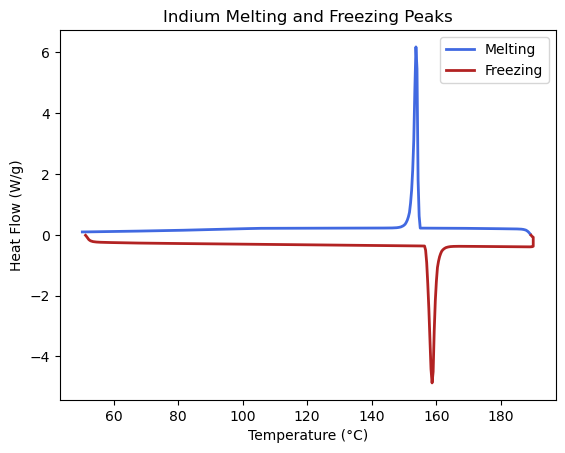

In [389]:
import matplotlib.pyplot as plt

# Example time ranges (adjust these based on your data)
indium_melting = {
    'path': path,
    'name': 'indium.txt',
    'label': 'In Melting',
    'time_start': 3,  # Adjust to capture melting peak
    'time_end': 900,    # Adjust to capture melting peak
    'baseline_type': 'line'
}
indium_freezing = {
    'path': path,
    'name': 'indium.txt',
    'label': 'In Freezing',
    'time_start': 3,  # Adjust to capture freezing peak
    'time_end': 900,    # Adjust to capture freezing peak
    'baseline_type': 'line'
}

# Filter data
filter_data(indium_melting)
filter_data(indium_freezing)

freezing_data = indium_freezing['filtered_data']
melting_data = indium_melting['filtered_data']

# Plot melting (positive heat flow, endothermic) in royalblue
melting_mask = melting_data['Heat-Flow'] > 0.01
plt.plot(
    melting_data['Tr'][melting_mask],
    melting_data['Heat-Flow'][melting_mask],
    label='Melting',  # Corrected label
    color='royalblue',
    linewidth=2
)

# Plot freezing (negative heat flow, exothermic) in firebrick
freezing_mask = freezing_data['Heat-Flow'] < 0
plt.plot(
    freezing_data['Tr'][freezing_mask],
    freezing_data['Heat-Flow'][freezing_mask],
    label='Freezing',  # Corrected label
    color='firebrick',
    linewidth=2
)

plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (W/g)')
plt.title('Indium Melting and Freezing Peaks')
plt.legend()
plt.show()

In [390]:
# Analyze peaks
analyze_peak(indium_melting, xaxis='Tr', verbose=False)
analyze_peak(indium_freezing, xaxis='Tr', verbose=False)

# Melting temperature (extrapolated peak)
Tm = indium_melting['extrapolated_peak'][0]
print(f"Melting Temperature (Tm): {Tm:.2f} °C")

# Freezing temperature (extrapolated peak)
Tf = indium_freezing['extrapolated_peak'][0]
print(f"Freezing Temperature (Tf): {Tf:.2f} °C")

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_33067/3345761861.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'dHF_dx'] = np.gradient(filtered_data['Heat-Flow'], filtered_dat

KeyError: 'Heat-Flow-Clean'

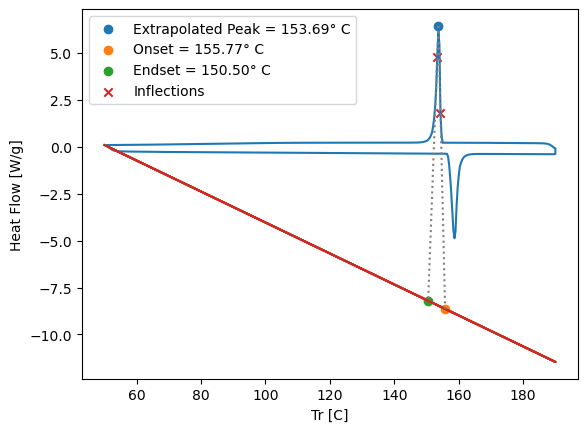

In [336]:
# if you have already run analyze_peak() and only want to make the plot, you can use the command below
plot_analysis(indium_freezing, xaxis='Tr') # note that xaxis here should be the same as the one you used for the analysis

* Plot the peaks corresponding to the two processes, without the baselines, in the same figure.

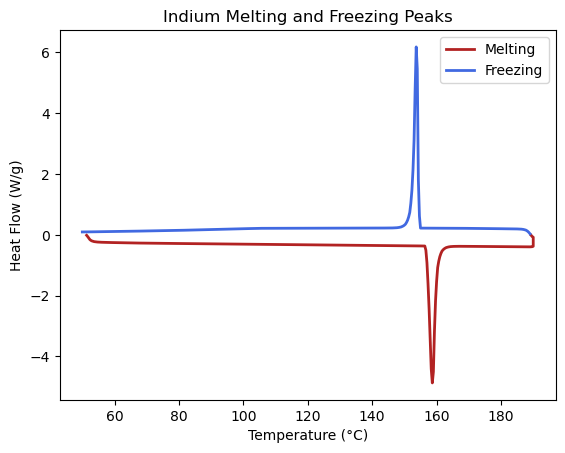

In [337]:

filter_data(indium_melting)
filter_data(indium_freezing)

freezing_data = indium_freezing['filtered_data']
melting_data = indium_melting['filtered_data']

# Plot only negative values (freezing) in firebrick
freezing_mask = freezing_data['Heat-Flow'] < 0
plt.plot(
    freezing_data['Tr'][freezing_mask],
    freezing_data['Heat-Flow'][freezing_mask],
    label='Melting',
    color='firebrick',
    linewidth=2
)

# Plot only positive values (melting) with threshold and updated color
melting_mask = melting_data['Heat-Flow'] > 0.01
plt.plot(
    melting_data['Tr'][melting_mask],
    melting_data['Heat-Flow'][melting_mask],
    label='Freezing',
    color='royalblue',
    linewidth=2
)

plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (W/g)')
plt.title('Indium Melting and Freezing Peaks')
plt.legend()
plt.show()

* Determine the melting and crystallization temperatures from the curves. Determine the melting and crystallization enthalpies. Discuss potential differences between these quantities.

In [338]:
# Assuming you have already run plot_peak_list and analyze_peak for both indium_melting and indium_freezing
analyze_peak(indium_melting, xaxis='Tr')
# Get Tm (melting temperature)
Tm = indium_melting['peak'][0]  # 'peak' contains (x_peak, y_peak)


print(f"Freezing Temperature (Tm): {Tm:.2f} °C")

# Get Tm from inflection point above x-axis (inflection1)
Tm = indium_melting['inflection1'][1]  # inflection1 contains (slope, x, y) → [1] is x
print(f"Melting Temperature (Tf): {Tm:.2f} °C")



Freezing Temperature (Tm): 153.67 °C
Melting Temperature (Tf): 154.33 °C


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12

* Report the measured mass of your sample. Calculate the normalized and molar enthalpies of melting and solidification of indium

In [339]:
0.068

0.068

In [340]:

mass = 0.068
print(f"The measured mass of the indium sample was {mass:.3f} g.")

# Melting data
Cp_m =  0.230
delta_T_m =  156.6
normalized_Hm = Cp_m * delta_T_m  # in J/g
molar_mass = 114.818
molar_Hm = normalized_Hm * molar_mass  # in J/mol

print(f"Normalized Melting Enthalpy: {normalized_Hm:.2f} J/g")
print(f"Molar Melting Enthalpy: {molar_Hm:.2f} J/mol")

# Crystallization data
analyze_peak(indium_freezing, xaxis='Tr')
delta_Hf = indium_freezing['integral']  # J/g
molar_Hf = delta_Hf * molar_mass        # J/mol

print(f"Normalized Freezing Enthalpy: {delta_Hf:.2f} J/g")
print(f"Molar Freezing Enthalpy: {molar_Hf:.2f} J/mol")


The measured mass of the indium sample was 0.068 g.
Normalized Melting Enthalpy: 36.02 J/g
Molar Melting Enthalpy: 4135.51 J/mol
Normalized Freezing Enthalpy: 5397.23 J/g
Molar Freezing Enthalpy: 619698.94 J/mol


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12

* Using the following equation, $T_m=\frac{\Delta H_{m}}{\Delta S_{m}}$, calculate the molar entropy from the molar enthalpy of melting.

In [341]:
molar_Hm = 4135  # J/mol
Tm = 156.6  # °C

Tm_kelvin = Tm + 273.15  # Convert Tm to Kelvin
molar_Sm = molar_Hm / Tm_kelvin  # J/mol·K

print(f"Molar Entropy of Melting: {molar_Sm:.2f} J/mol·K")

Molar Entropy of Melting: 9.62 J/mol·K


## Task 2: Phase Transitions in Paracetatmol (a.k.a. Acetominophene) {-}

In your second experiment you have looked at the phase transitions in one of the most popular drugs. Paracetamol exhibit three non morphisms (forms I-III). You performed two melting runs on the pristine sample and on a melted sample that was cooled at room temperature. 

* Plot the two runs and compare the two different heating curves.

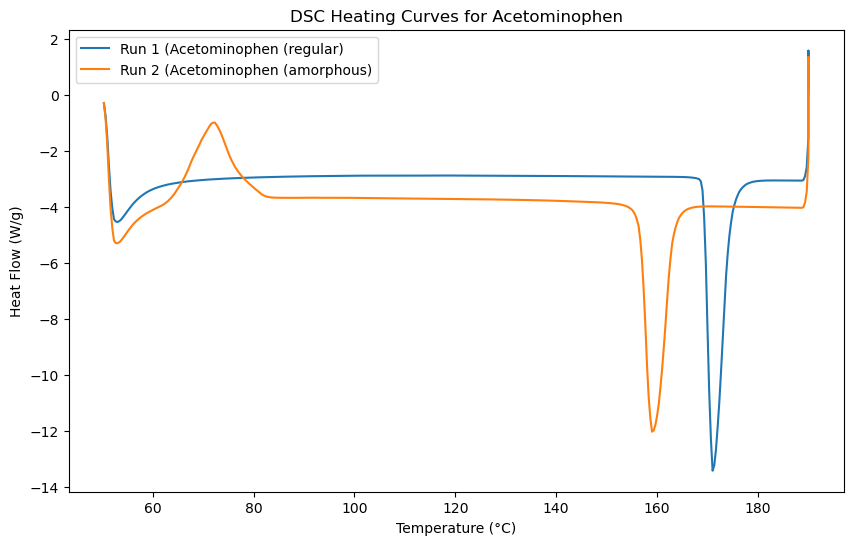

In [342]:
# Define peak dictionaries for each run
paracetamol_run1 = {'path': path, 'name': 'aCETE.txt', 'label': 'Run 1', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}
paracetamol_run2 = {'path': path, 'name': 'aCETE2.txt', 'label': 'Run 2', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}

# Load data into the peak dictionaries
load_data_to_file_dict(paracetamol_run1)
load_data_to_file_dict(paracetamol_run2)

# Filter data based on time_start and time_end (if specified)
filter_data(paracetamol_run1)
filter_data(paracetamol_run2)

# Plot the two runs on the same graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(paracetamol_run1['filtered_data']['Tr'], paracetamol_run1['filtered_data']['Heat-Flow'], label='Run 1 (Acetominophen (regular)')
plt.plot(paracetamol_run2['filtered_data']['Tr'], paracetamol_run2['filtered_data']['Heat-Flow'], label='Run 2 (Acetominophen (amorphous)')

# Set axis labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (W/g)')
plt.title('DSC Heating Curves for Acetominophen')

# Add a legend
plt.legend()

# Show the plot
plt.show()

* Determine the melting temperature and the melting enthalpy for all the transitions in the two runs.

In [343]:
# Define peak dictionaries for each run
paracetamol_run1 = {'path': path, 'name': 'aCETE.txt', 'label': 'Run 1', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}
paracetamol_run2 = {'path': path, 'name': 'aCETE2.txt', 'label': 'Run 2', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}

# Load data into the peak dictionaries
load_data_to_file_dict(paracetamol_run1)
load_data_to_file_dict(paracetamol_run2)

# Analyze each peak for Run 1
analyze_peak(paracetamol_run1, xaxis='Ts', verbose=False)  # Use xaxis='Ts' for temperature

# Analyze each peak for Run 2
analyze_peak(paracetamol_run2, xaxis='Ts', verbose=False)  # Use xaxis='Ts' for temperature

# Print the results
print("\nRun 1:")
print(f"Melting Temperature: {paracetamol_run1['extrapolated_peak'][0]:.2f} °C")  # Assuming extrapolated_peak is used for melting temperature
print(f"Melting Enthalpy: {paracetamol_run1['integral']:.2f} J/g")

print("\nRun 2:")
print(f"Melting Temperature: {paracetamol_run2['extrapolated_peak'][0]:.2f} °C")  # Assuming extrapolated_peak is used for melting temperature
print(f"Melting Enthalpy: {paracetamol_run2['integral']:.2f} J/g")


Run 1:
Melting Temperature: 173.14 °C
Melting Enthalpy: -1335.21 J/g

Run 2:
Melting Temperature: 175.81 °C
Melting Enthalpy: -1570.46 J/g


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/opt/anaconda3/lib/python3.12

* Report the mass of your sample. Calculate the normalized (in kJ/g) and molar (in kJ/mol) enthalpies. 

In [344]:
# write your math here
# 1. Report the Measured Mass (replace with your actual measured mass)
mass = 0.062
print(f"The measured mass of the acete sample was {mass:.3f} g.")

Cp_m =  0.223
delta_T =  173.14

normalized_Hm = Cp_m * delta_T # in J/g
print(f"Normalized Melting Enthalpy: {normalized_Hm:.2f} J/g")

molar_mass = 151.163

molar_Hm = normalized_Hm * molar_mass  # in J/mol
print(f"Molar Melting Enthalpy: {molar_Hm:.2f} J/mol")

The measured mass of the acete sample was 0.062 g.
Normalized Melting Enthalpy: 38.61 J/g
Molar Melting Enthalpy: 5836.44 J/mol


* Using the following equation $T_m=\frac{\Delta H_{m}}{\Delta S_{m}},$ compute the molar entropy from the molar enthalpy of melting.

In [345]:
molar_Hm = 5470  # J/mol
Tm = 173.14 # °C

Tm_kelvin = Tm + 273.15  # Convert Tm to Kelvin
molar_Sm = molar_Hm / Tm_kelvin  # J/mol·K

print(f"Molar Entropy of Melting: {molar_Sm:.2f} J/mol·K")

Molar Entropy of Melting: 12.26 J/mol·K


* Discuss why the two spectra look different. Assuming that the first spectrum is from a crystalline sample (i.e. one of the three polymorphs of paracetamol), determine which form you started with. 

The two DSC spectra differ due to the physical state of the paracetamol. The first run exhibits a sharp melting endotherm at 173.14 °C with an enthalpy of –1335.21 J/g, which is characteristic of Form I, the most stable and commonly encountered crystalline polymorph of paracetamol. This well-ordered structure results in a consistent, defined thermal transition denoted by the singular peak at 173. In contrast, the second run—performed on a previously melted and cooled sample demonstrates a slightly broader endotherm at a higher melting temperature of 175.81 °C and a larger enthalpy of –1570.46 J/g. This suggests that the material initially existed in a less-ordered or amorphous state and then recrystallized into a more ordered crystalline form during the second heating cycle. The increase in both melting point and enthalpy supports the formation of a more stable, well-packed structure upon reheating, likely returning to something similar to Form I.

## Task 3: Melting Temperature of your Unknown {-}

In your last experiment you have looked at the melting transition of an unknown compound. 

* Plot the DSC curve for your unknown material.

The peak integral is -31.609005 J/g


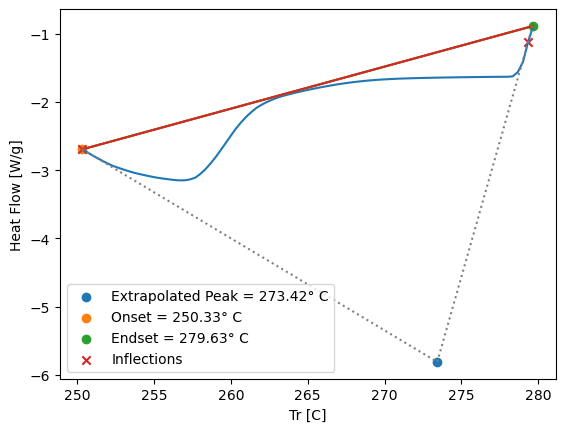

In [346]:
#blue fabric = unknown = unk.txt
unknown_melting = {'path':path, 'name':'unk.txt', 'label':'In Melting', 'time_start': 600, 'time_end': 690, 'baseline_type': 'line'}
unknown_peaks = [unknown_melting]

analyze_peak(unknown_melting, xaxis='Tr', verbose=True)

* Determine the melting transition temperature.

The melting transition temperature of the unknown sample, based on the DSC analysis, is approximately 273.4 °C. This value corresponds to the extrapolated peak temperature, which represents the most accurate estimate of the material’s melting point from the DSC curve. The onset temperature is 250.3 °C, and the melting end temp is 279.6 °C, confirming a sharp and well-defined melting process.

* Make an educated guess on what your unkown material is.

Based on data, the unknown material exhibits a sharp melting transition with an extrapolated peak temperature of 273.4 °C, an onset of 250.3 °C, and an endset of 279.6 °C. These values are consistent with the melting behavior of polyester, which is commonly used in synthetic fabrics such as the blue textile unknown. Polyester typically shows a narrow and well-defined melting range between 250–280 °C, aligning closely with the data observed here. Therefore, an educated guess would be that the unknown material is a crystalline polyester fabric, most likely a form of polyethylene terephthalate (PET).

## Task 4: Discussion {-}

* Add your results and the correspnding literature values in the following table.

In [347]:

data = {
    "Substance": ["Indium", "Acetaminophen", "Unknown (PET)"],
    "Measured Mass (g)": [0.068, 0.062, "—"],
    "Melting Temp (°C)": [156.6, 173.14, 273.4],
    "ΔHm (J/g)": [36.02, 38.61, "—"],
    "ΔHm (J/mol)": [4135.51, 5836.44, "—"],
    "Lit. Tm (°C)": [156.6, "169–174", "250–280"],
    "Lit. ΔHm (J/mol)": [4280, "~5900", "140–200 J/g"]
}

# Create and display the dataframe
df = pd.DataFrame(data)
print(df.to_markdown(index=False))

| Substance     | Measured Mass (g)   |   Melting Temp (°C) | ΔHm (J/g)   | ΔHm (J/mol)   | Lit. Tm (°C)   | Lit. ΔHm (J/mol)   |
|:--------------|:--------------------|--------------------:|:------------|:--------------|:---------------|:-------------------|
| Indium        | 0.068               |              156.6  | 36.02       | 4135.51       | 156.6          | 4280               |
| Acetaminophen | 0.062               |              173.14 | 38.61       | 5836.44       | 169–174        | ~5900              |
| Unknown (PET) | —                   |              273.4  | —           | —             | 250–280        | 140–200 J/g        |


* Discuss on the possible sources of discrepancy between your experiments and the literature. 

Discrepancies between experimental and literature values can be attributed to several factors. For acetaminophen, the preparation process and potential presence of impurities or residual synthesis byproducts can significantly alter the observed enthalpy. Such impurities may broaden or distort the melting peak, ergo lowering the calculated ΔH value. The reference sample itself may also be defective—whether through contamination or degradation (likely the latter)—engendering further deviation from expected results. Indium is typically a high-purity calibration standard and generally yields more reliable values. However, in this case, even the indium showed a slightly aberrant (lower-than-expected) enthalpy. This could suggest issues with instrumental calibration, baseline error, or mishandling/poor prep of the reference material. It’s possible the reference or the indium itself was altered or exposed to conditions that  reduced its apparent thermal output.

* In what field is DSC would be useful? Give 2-3 examples.

Differential Scanning Calorimetry (DSC) is one of the most powerful analytical tools (imo; barring MS). In the pharmaceutical industry, DSC is necessary for assessing the purity of drug compounds. Since different crystalline forms of a drug can vary in properties like solubility, bioavailability, and stability, and efficacy, DSC is routinely employed during formulation and quality control processes. In polymer science, DSC is widely used to determine key thermal properties such as the glass transition temperature (Tg), melting point (Tm), and crystallization behavior. These thermal parameters are critical for material behavior, also for understanding how polymers will perform during manufacturing and in their various applications. In food science DSC is utilized to characterize the thermal behavior of fats and oils, which can help ensure consistency in texture, melting properties, and shelf-life. This is particularly important in products like perishable, heat labile products, where the precise crystalline form of fat affects  quality and longevity.

In [348]:

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

zsh:1: command not found: apt-get


In [349]:


!jupyter nbconvert --no-input --to PDF "/content/drive/MyDrive/Colab Notebooks/DSC_Workshee.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/DSC_Workshee.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--J